## Overview

In this tutorial, we will build a simple aritificial neural network (ANN), also known as multilayer perceptron (MLP) or feedforward neural network (FNN). The learning outcomes are:
1. Understand how the model is formulated mathematically;
2. Understand what is meant by training the network;
3. Experiment with more complex architectures.

## Data

We generate data from a Gaussian process with a specified covariance matrix. The details of data generation do not matter as in reality, you never know the actual data generation machanism.

**The key** here is that we want to predict $y \in R^5$ given the previous values $x\in R^{25}$.

In [1]:
# first let's generate data, you can ignore this part
import numpy as np

# generate 10000 points from multivariate gaussian with 30 dimensions
cov = np.cov(np.random.randn(30, 10))
mean = np.zeros(30)
X = np.random.multivariate_normal(mean, cov, 10000)

# split into train and test
X_train = X[:8000, :25]
X_val = X[8000:9000, :25]
X_test = X[9000:, :25]
y_train = X[:8000, 25:] + np.random.randn(8000, 5)
y_val = X[8000:9000, 25:] + np.random.randn(1000, 5)
y_test = X[9000:, 25:] + np.random.randn(1000, 5)

# set up torch dataset
import torch
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
# set up torch dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Linear regression

Suppose we want to model our data as a linear transformation, that is we aim to find $W \in R^{25\times 5}$ so that to minimize the squared error between the prediction and the truth. In summary, we formulate the problem as:
$$
W^* = \argmin_{W} || Y -  XW ||^2
$$

This model is an extension of the model many of us have covered in the introductory statisics courses to a multivariate case. **Recall** that for one-dimensional case (i.e. when $y \in R$) and under some distributional assumptions, this optimization problem has a closed form solution that is guaranteed to be the best (BLUE). When we move to more dimensions and start relaxing the assumptions, we no longer have the closed-form solution. Hence, we need to resort to the apprximate methods. Below, we program the model and see its performance.

In [2]:
import torch
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(25, 5)
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [3]:
# train model
best_loss = 1e10
model = LinearModel()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model.pth')
# load best model
model.load_state_dict(torch.load('best_model.pth'))
    

Epoch [1/100], Loss: 1.1557
Epoch [1/100], Val Loss: 1.2474
Epoch [2/100], Loss: 1.0232
Epoch [2/100], Val Loss: 1.1688
Epoch [3/100], Loss: 0.9448
Epoch [3/100], Val Loss: 1.1739
Epoch [4/100], Loss: 0.9088
Epoch [4/100], Val Loss: 1.1468
Epoch [5/100], Loss: 1.0772
Epoch [5/100], Val Loss: 1.1537
Epoch [6/100], Loss: 0.8697
Epoch [6/100], Val Loss: 1.1597
Epoch [7/100], Loss: 1.0032
Epoch [7/100], Val Loss: 1.1559
Epoch [8/100], Loss: 0.9870
Epoch [8/100], Val Loss: 1.1600
Epoch [9/100], Loss: 0.9969
Epoch [9/100], Val Loss: 1.1975
Epoch [10/100], Loss: 1.2031
Epoch [10/100], Val Loss: 1.1654
Epoch [11/100], Loss: 1.0776
Epoch [11/100], Val Loss: 1.1653
Epoch [12/100], Loss: 1.0057
Epoch [12/100], Val Loss: 1.1677
Epoch [13/100], Loss: 1.0684
Epoch [13/100], Val Loss: 1.1643
Epoch [14/100], Loss: 1.1931
Epoch [14/100], Val Loss: 1.1527
Epoch [15/100], Loss: 0.9567
Epoch [15/100], Val Loss: 1.1747
Epoch [16/100], Loss: 0.9822
Epoch [16/100], Val Loss: 1.1771
Epoch [17/100], Loss: 0.90

<All keys matched successfully>

In [4]:
# evaluate model on test set
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 0.9426


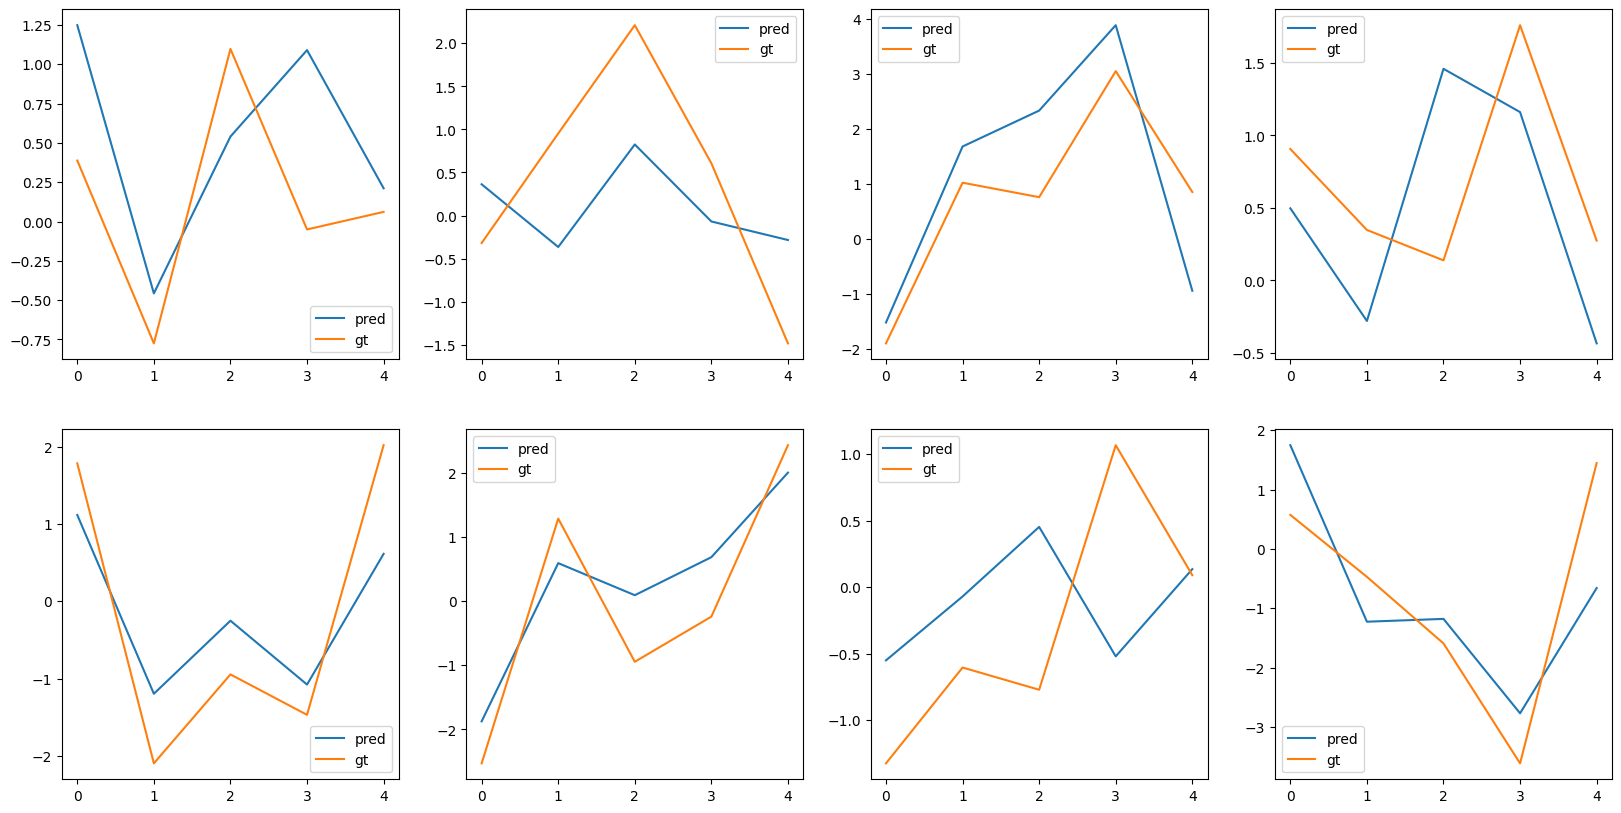

In [5]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()

## Can we do better?

In our case, there is little justification to move beyond the linear regression setting because of how the data is generated. Nevertheless, nobody is stopping us from trying. Let's now formulate our model as: $$\hat y  = (ReLU(XW^{(1)})) W^{(2)},$$
where $W^{(1)} \in R^{25 \times n_1}, W^{(2)} \in R^{n_1 \times 5}$ are learnable weight matrie and $n_1$ is a hyper-parameter we get to choose.

The main points we want to you to notice from this example are:
1. More complex models do not mean better performance;
2. Hyper-parameter tuning is tedious;
3. **Most importantly**, we can learn any differentiable architecture with the help of SGD.

In [6]:
# define model
import torch
class MLP(torch.nn.Module):
    def __init__(self, n1):
        super(MLP, self).__init__()
        self.linear = torch.nn.Linear(25, n1)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(n1, 5)
        
    def forward(self, x):
        y_pred = self.linear2(self.relu(self.linear(x)))
        return y_pred

In [7]:
# train model
best_loss = 1e10
model = MLP(100)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model.pth')
# load best model
model.load_state_dict(torch.load('best_model.pth'))

Epoch [1/100], Loss: 1.1706
Epoch [1/100], Val Loss: 1.5028
Epoch [2/100], Loss: 1.1237
Epoch [2/100], Val Loss: 1.2813
Epoch [3/100], Loss: 0.8899
Epoch [3/100], Val Loss: 1.2026
Epoch [4/100], Loss: 0.9536
Epoch [4/100], Val Loss: 1.1891
Epoch [5/100], Loss: 0.9130
Epoch [5/100], Val Loss: 1.1964
Epoch [6/100], Loss: 0.9741
Epoch [6/100], Val Loss: 1.1935
Epoch [7/100], Loss: 1.1615
Epoch [7/100], Val Loss: 1.1931
Epoch [8/100], Loss: 0.9202
Epoch [8/100], Val Loss: 1.1792
Epoch [9/100], Loss: 1.2654
Epoch [9/100], Val Loss: 1.1885
Epoch [10/100], Loss: 1.0240
Epoch [10/100], Val Loss: 1.1962
Epoch [11/100], Loss: 1.0928
Epoch [11/100], Val Loss: 1.1767
Epoch [12/100], Loss: 0.8548
Epoch [12/100], Val Loss: 1.1888
Epoch [13/100], Loss: 1.1994
Epoch [13/100], Val Loss: 1.1965
Epoch [14/100], Loss: 1.0616
Epoch [14/100], Val Loss: 1.1797
Epoch [15/100], Loss: 1.0286
Epoch [15/100], Val Loss: 1.1814
Epoch [16/100], Loss: 1.1200
Epoch [16/100], Val Loss: 1.1822
Epoch [17/100], Loss: 0.87

<All keys matched successfully>

In [9]:
# evaluate model on test set
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 0.9659


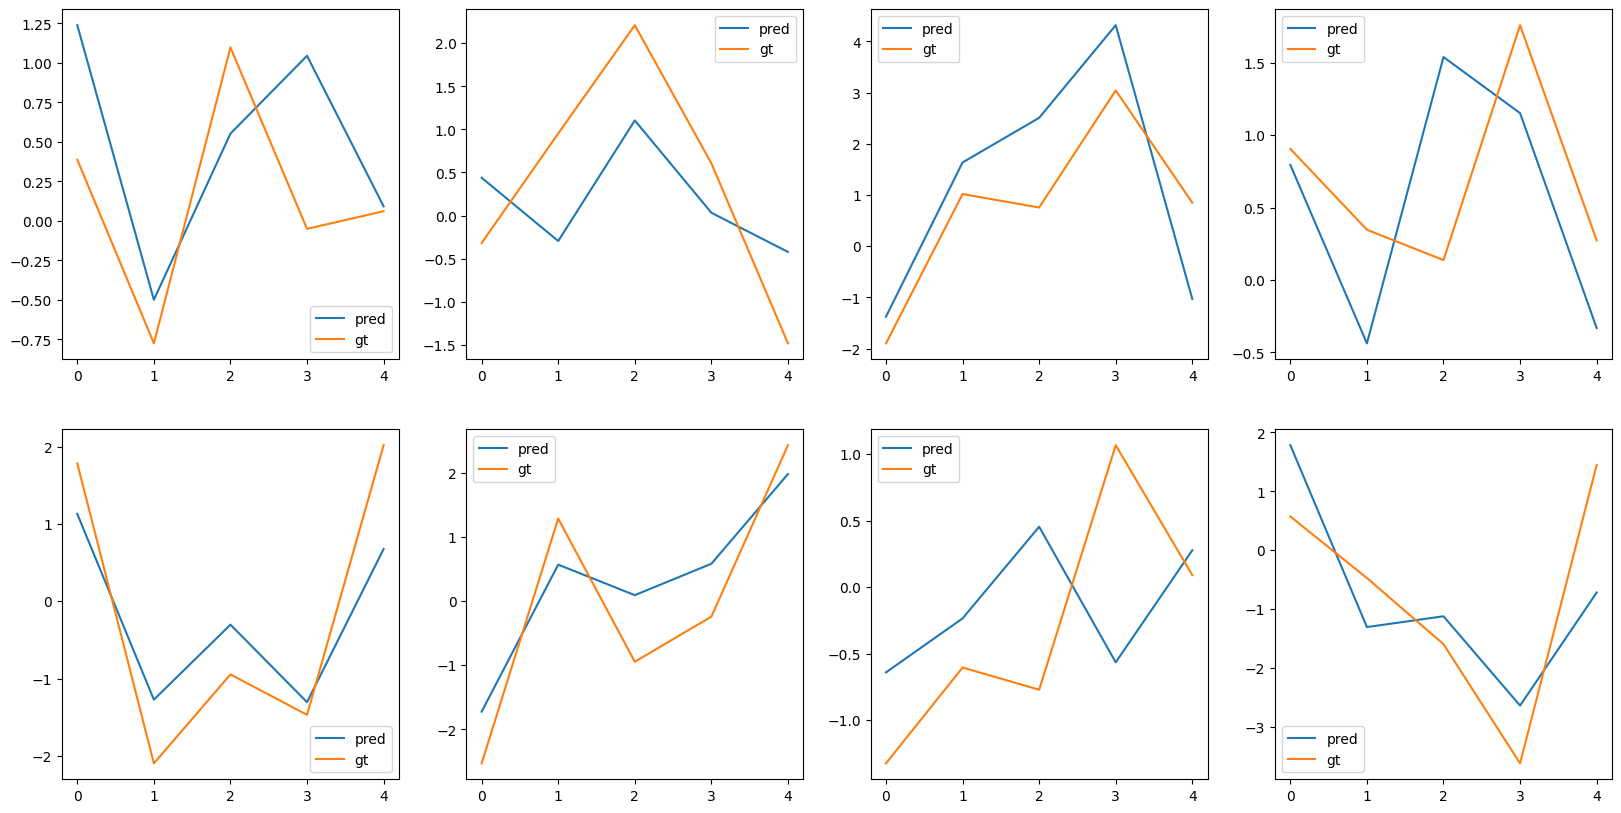

In [10]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()